In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/bin/python
3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.0.13.3)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C

In [3]:
# Load dataset
df = pd.read_csv("design_out.csv")

# Remove sigma_mem_y as it represents the membrane stress and is used to calculate probability of failure
# Not a model parametere which influences the model but helps to calculate the structure failure probability
df = df[['f_mem','sigma_mem','E_mem','nu_mem','sigma_edg','sigma_sup','sigma_mem_max']]
df.head() # 200 x 7

,f_mem,sigma_mem,E_mem,nu_mem,sigma_edg,sigma_sup,sigma_mem_max
0,0.268767,3220.880252,620830.965150,0.399472,325851.235578,322000.762345,4204.095289
1,0.511186,4603.969420,559505.773241,0.398297,266690.745363,366814.407254,5578.199692
2,0.316207,4020.464157,664063.602748,0.393333,350103.330214,308367.205040,4688.809620
3,0.457326,4282.802400,622714.404090,0.411230,313489.897816,327438.702828,5219.281260
4,0.261861,4097.033516,623600.545225,0.382459,334400.590712,474471.127871,4986.756515


In [4]:
# Split into features (X) and target (y)
X = df.iloc[:, :-1]  # all columns except last
y = df.iloc[:, -1]   # last column = response

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# print the features and response names 
print("Response name:", y.name)
print("Feature names:", X.columns.tolist())

Features shape: (200, 6)
Target shape: (200,)
Response name: sigma_mem_max
Feature names: ['f_mem', 'sigma_mem', 'E_mem', 'nu_mem', 'sigma_edg', 'sigma_sup']


In [5]:
# Split the data into training and testing sets 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1) SVR Model

In [6]:
# Build pipeline 
# First standardize the data, then fit SVR model
pipeline = make_pipeline(StandardScaler(), SVR())

# Define search grid
param_grid = {
    "svr__C": [0.1, 1, 10, 100, 1000],
    "svr__epsilon": [0.001, 0.01, 0.1, 0.5, 1],
    "svr__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]  # scale : (1 / (n_features * X.var())) and auto : (1 / n_features)  
}

# Run grid search with 5-fold CV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best R2 Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)




Best R2 Score: 0.9917558681931682
Best Parameters: {'svr__C': 1000, 'svr__epsilon': 0.001, 'svr__gamma': 0.01}


In [7]:
# Build final SVR model with optimal hyperparameters
svr = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=grid.best_params_['svr__C'], epsilon=grid.best_params_['svr__epsilon'], gamma=grid.best_params_['svr__gamma'])
)

# Fit on the FULL dataset (not train/test split)
svr.fit(X_train, y_train)

y_train_pred_svr = svr.predict(X_train)
y_test_pred_svr = svr.predict(X_test)

In [8]:
# Training metrics
r2_train_svr = r2_score(y_train, y_train_pred_svr)
mse_train_svr = mean_squared_error(y_train, y_train_pred_svr)

# Test metrics
r2_test_svr = r2_score(y_test, y_test_pred_svr)
mse_test_svr = mean_squared_error(y_test, y_test_pred_svr)


In [9]:
# Create datafram for errors storage with row names as model names and columns as Train and Test errors
errors_df = pd.DataFrame(
    data={
        "R2_Train": [r2_train_svr],
        "R2_Test": [r2_test_svr],
        "MSE_Train": [mse_train_svr],
        "MSE_Test": [mse_test_svr]
    },
    index=["SVR"]
)

# Save the trained model
joblib.dump(svr, "svr.pkl")

errors_df



,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR,0.996683,0.997066,693.722777,1080.806261


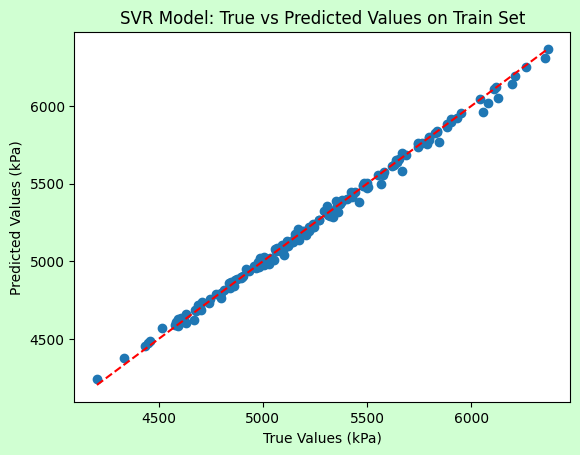

In [10]:
# Scatter plot of true vs predicted values

# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background


plt.scatter(y_train, y_train_pred_svr)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True Values (kPa)")
plt.ylabel("Predicted Values (kPa)")
plt.title("SVR Model: True vs Predicted Values on Train Set")
plt.savefig("results/SVR_train.png", dpi=300, bbox_inches="tight")
plt.show()

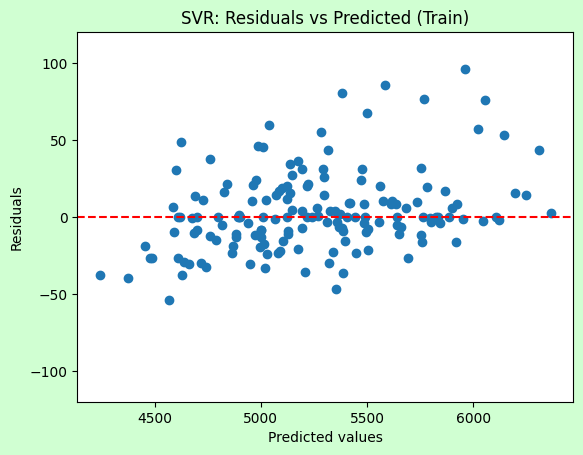

In [11]:

residuals_train_svr = y_train - y_train_pred_svr

# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

plt.scatter(y_train_pred_svr, residuals_train_svr)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (kPa)")
plt.ylabel("Residuals (kPa)")
plt.title("SVR: Residuals vs Predicted (Train)")
ax.set_ylim(-120, 120)
plt.savefig("results/SVR_res_train.png", dpi=300, bbox_inches="tight")
plt.show()


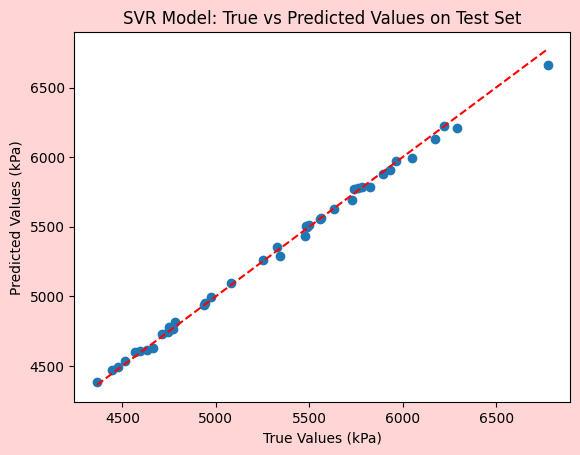

In [12]:
# Scatter plot of true vs predicted values

# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background



plt.scatter(y_test, y_test_pred_svr)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values (kPa)")
plt.ylabel("Predicted Values (kPa)")
plt.title("SVR Model: True vs Predicted Values on Test Set")
plt.savefig("results/SVR_test.png", dpi=300, bbox_inches="tight")
plt.show()

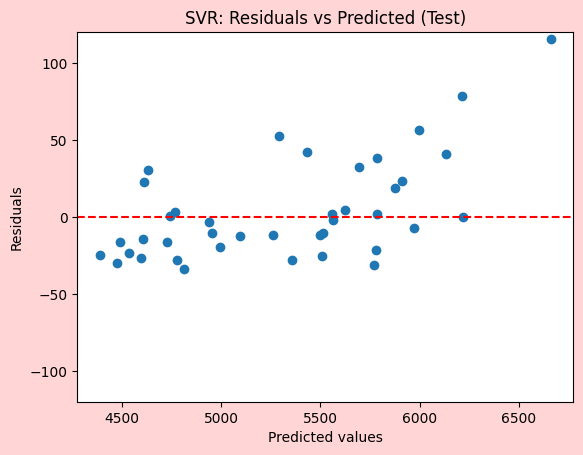

In [13]:
residuals_test_svr = y_test - y_test_pred_svr

fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

plt.scatter(y_test_pred_svr, residuals_test_svr)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (kPa)")
plt.ylabel("Residuals (kPa)")
plt.title("SVR: Residuals vs Predicted (Test)")
ax.set_ylim(-120, 120)
plt.savefig("results/SVR_res_test.png", dpi=300, bbox_inches="tight")
plt.show()

## PI with Bootstrap

from sklearn.utils import resample
from sklearn.base import clone
from joblib import Parallel, delayed   # pip install joblib if needed

B = 10000
base_model = svr   # your pipeline
n_test = X_test.shape[0]

def one_bootstrap_seed(b):
    # bootstrap sample
    Xb, yb = resample(X_train, y_train, replace=True, random_state=b)
    m = clone(base_model)
    m.fit(Xb, yb)
    return m.predict(X_test)   # shape (n_test,)

# n_jobs=-1 uses all cores; you can set e.g. n_jobs=4
all_preds_list = Parallel(n_jobs=-1, backend="loky")(
    delayed(one_bootstrap_seed)(b) for b in range(B)
)

all_svr_test_preds = np.vstack(all_preds_list)  # shape (B, n_test)

# point prediction
y_pred_svr_boot = np.median(all_svr_test_preds, axis=0)

# 95% prediction intervals
alpha = 0.05
lower_svr_test_PI = np.quantile(all_svr_test_preds, alpha/2,     axis=0)
upper_svr_test_PI = np.quantile(all_svr_test_preds, 1 - alpha/2, axis=0)


## 2) Polynomial Regression 

In [14]:
# List of degrees to try
degrees = [1, 2, 3, 4, 5, 6]

best_degree = None
best_mse = float('inf')
mse_scores_per_degree = []

for degree in degrees:
    # Create pipeline: polynomial features + scaling + linear regression
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        LinearRegression(fit_intercept=True)
    )
    
    # 5-fold cross-validation for MSE (negative because cross_val_score maximizes score)
    neg_mse_scores = cross_val_score(model, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                     scoring=make_scorer(mean_squared_error))
    mse_scores = neg_mse_scores.mean()  # Average MSE across folds
    mse_scores_per_degree.append(mse_scores)
    
    print(f"Degree {degree}: Mean 5-CV MSE = {mse_scores:.4f}")
    
    # Keep track of the best degree
    if mse_scores < best_mse:
        best_mse = mse_scores
        best_degree = degree

print(f"\nBest degree based on 5-CV MSE: {best_degree}")

# Fit final model with best degree on full training data
poly = make_pipeline(
    PolynomialFeatures(degree=best_degree, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=True)
)

poly.fit(X_train, y_train)

# Predictions
y_train_pred_poly = poly.predict(X_train)
y_test_pred_poly = poly.predict(X_test)

# Training and test metrics

r2_train_poly = r2_score(y_train, y_train_pred_poly)
mse_train_poly = mean_squared_error(y_train, y_train_pred_poly)
r2_test_poly = r2_score(y_test, y_test_pred_poly)
mse_test_poly = mean_squared_error(y_test, y_test_pred_poly)

print(f"\nTraining R²: {r2_train_poly:.4f}, MSE: {mse_train_poly:.4f}")
print(f"Test R²: {r2_test_poly:.4f}, MSE: {mse_test_poly:.4f}")

Degree 1: Mean 5-CV MSE = 3776.0046
Degree 2: Mean 5-CV MSE = 217.9354
Degree 3: Mean 5-CV MSE = 224.4187
Degree 4: Mean 5-CV MSE = 552.8711
Degree 5: Mean 5-CV MSE = 580.8720
Degree 6: Mean 5-CV MSE = 642.9481

Best degree based on 5-CV MSE: 2

Training R²: 0.9995, MSE: 110.2521
Test R²: 0.9996, MSE: 137.5833


In [15]:
joblib.dump(poly, "poly.pkl")

# Errors from Polynomial Regression
errors_df.loc["PLY"] = [r2_train_poly, r2_test_poly, mse_train_poly, mse_test_poly]

# Display updated DataFrame
errors_df


,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR,0.996683,0.997066,693.722777,1080.806261
PLY,0.999473,0.999627,110.252095,137.583329


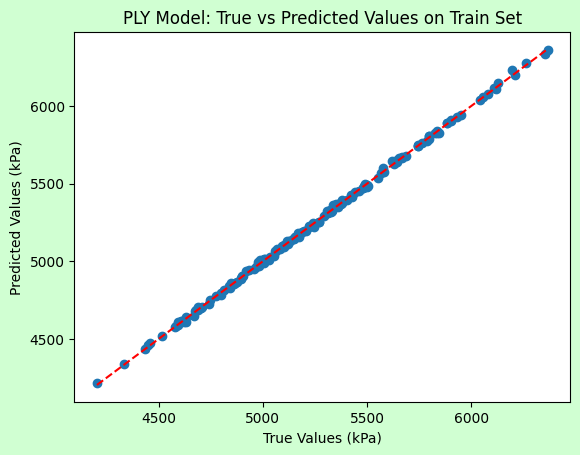

In [16]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

# Scatter plot of true vs predicted values
plt.scatter(y_train, y_train_pred_poly)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True Values (kPa)")
plt.ylabel("Predicted Values (kPa)")
plt.title("PLY Model: True vs Predicted Values on Train Set")
plt.savefig("results/PLY_train.png", dpi=300, bbox_inches="tight")
plt.show()

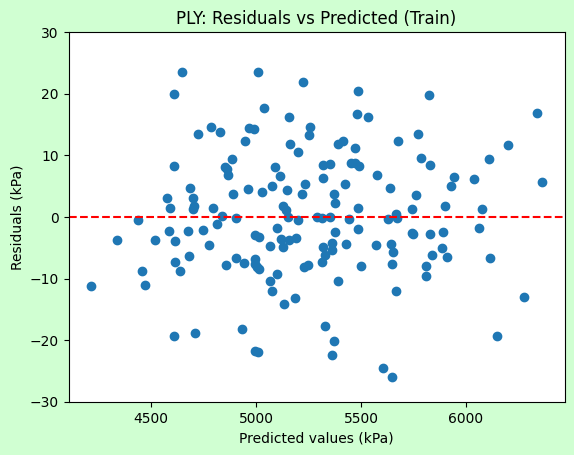

In [17]:

residuals_train_poly = y_train - y_train_pred_poly

fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

plt.scatter(y_train_pred_poly, residuals_train_poly)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (kPa)")
plt.ylabel("Residuals (kPa)")
plt.title("PLY: Residuals vs Predicted (Train)")
ax.set_ylim(-30, 30)
plt.savefig("results/PLY_res_train.png", dpi=300, bbox_inches="tight")
plt.show()

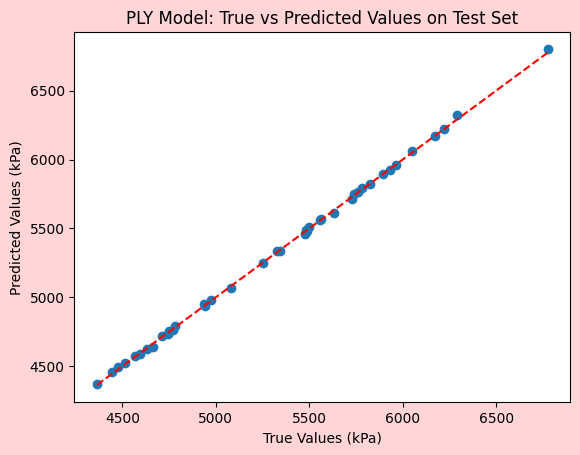

In [18]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background




# Scatter plot of true vs predicted values
plt.scatter(y_test, y_test_pred_poly)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values (kPa)")
plt.ylabel("Predicted Values (kPa)")
plt.title("PLY Model: True vs Predicted Values on Test Set")
plt.savefig("results/PLY_test.png", dpi=300, bbox_inches="tight")
plt.show()

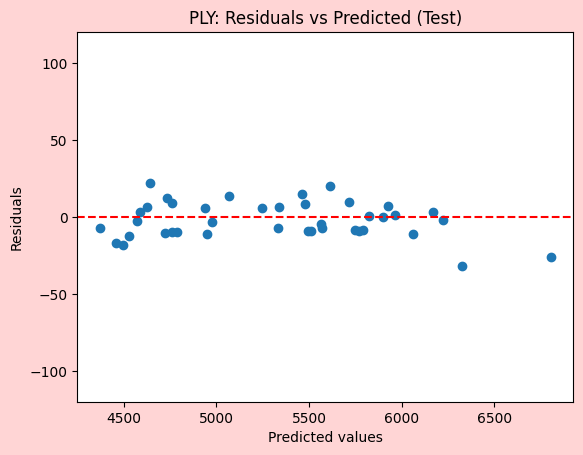

In [19]:

residuals_test_poly = y_test - y_test_pred_poly
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

plt.scatter(y_test_pred_poly, residuals_test_poly)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (kPa)")
plt.ylabel("Residuals (kPa)")
plt.title("PLY: Residuals vs Predicted (Test)")
ax.set_ylim(-120, 120)
plt.savefig("results/PLY_res_test.png", dpi=300, bbox_inches="tight")
plt.show()

## PI for Poly
with Assumption that the variance is homogenous among the output

In [20]:
from scipy.stats import norm

In [21]:
sigma_poly_hat = residuals_train_poly.std(ddof=1)   # global noise estimate
sigma_poly_hat

np.float64(10.53306718108375)

In [22]:
alpha = 0.05  # 95% PI
z = norm.ppf(1 - alpha/2)

In [23]:
lower_poly = y_test_pred_poly - z * sigma_poly_hat
upper_poly = y_test_pred_poly + z * sigma_poly_hat

## 3) GPR

In [24]:

# Scale features
scaler = StandardScaler()

# Define kernel: Constant * RBF
# kernel = C(1.0, (1e-3, 1e6)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e2))
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
# kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5)




# Initialize Gaussian Process Regressor
gpr = make_pipeline(
    StandardScaler(),
    GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
)

# Fit model
gpr.fit(X_train, y_train)

# print(gpr.kernel_)
# Predictions
y_train_pred_gp, y_train_std_gp = gpr.predict(X_train, return_std=True)
y_test_pred_gp, y_test_std_gp = gpr.predict(X_test, return_std=True)

# Metrics
r2_train_gp = r2_score(y_train, y_train_pred_gp)
mse_train_gp = mean_squared_error(y_train, y_train_pred_gp)
r2_test_gp = r2_score(y_test, y_test_pred_gp)
mse_test_gp = mean_squared_error(y_test, y_test_pred_gp)

print(f"Gaussian Process Regression -> Training R²: {r2_train_gp:.4f}, MSE: {mse_train_gp:.4f}")
print(f"Gaussian Process Regression -> Test R²: {r2_test_gp:.4f}, MSE: {mse_test_gp:.4f}")
print(gpr.named_steps['gaussianprocessregressor'].kernel_)


Gaussian Process Regression -> Training R²: 0.9997, MSE: 67.6425
Gaussian Process Regression -> Test R²: 0.9998, MSE: 80.2773
5.44**2 * RBF(length_scale=13.6) + WhiteKernel(noise_level=0.001)


/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [25]:
joblib.dump(gpr, "gpr.pkl")

# Errors from Gaussian Regression
errors_df.loc["GPR"] = [r2_train_gp, r2_test_gp, mse_train_gp, mse_test_gp]

# Display updated DataFrame
errors_df





,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR,0.996683,0.997066,693.722777,1080.806261
PLY,0.999473,0.999627,110.252095,137.583329
GPR,0.999677,0.999782,67.642432,80.277353


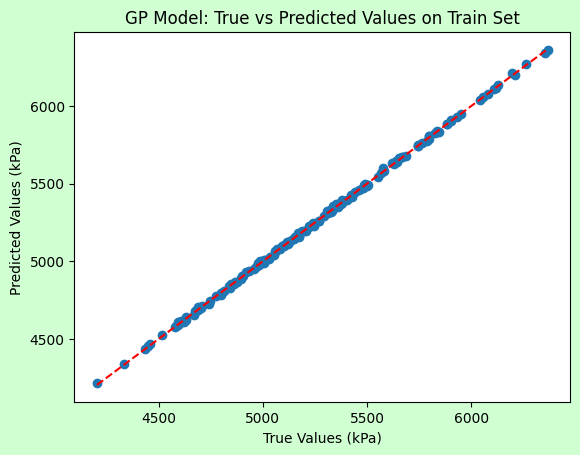

In [26]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

# Scatter plot of true vs predicted values
plt.scatter(y_train, y_train_pred_gp)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True Values (kPa)")
plt.ylabel("Predicted Values (kPa)")
plt.title("GP Model: True vs Predicted Values on Train Set")
plt.savefig("results/GP_train.png", dpi=300, bbox_inches="tight")
plt.show()

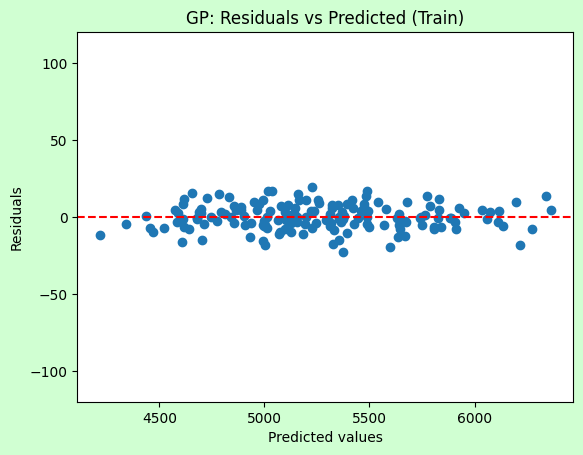

In [27]:
residuals_train_gp = y_train - y_train_pred_gp

fig, ax = plt.subplots()
fig.patch.set_facecolor("#00ff0d2f")  # figure background

plt.scatter(y_train_pred_gp, residuals_train_gp)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (kPa)")
plt.ylabel("Residuals (kPa)")
plt.title("GP: Residuals vs Predicted (Train)")
ax.set_ylim(-120, 120)
plt.savefig("results/GP_res_train.png", dpi=300, bbox_inches="tight")
plt.show()

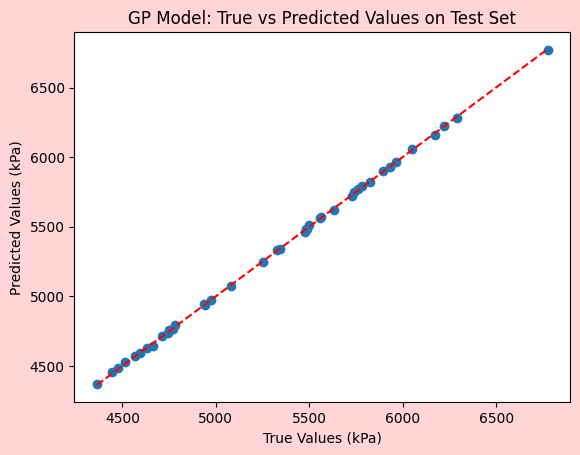

In [28]:
# --- Train plot (green-ish) ---
fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_test_pred_gp)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values (kPa)")
plt.ylabel("Predicted Values (kPa)")
plt.title("GP Model: True vs Predicted Values on Test Set")
plt.savefig("results/GP_test.png", dpi=300, bbox_inches="tight")
plt.show()

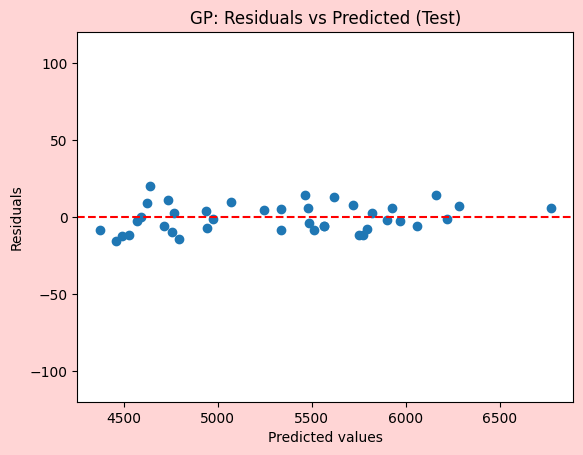

In [29]:
residuals_test_gp = y_test - y_test_pred_gp

fig, ax = plt.subplots()
fig.patch.set_facecolor("#ff00002a")  # figure background

plt.scatter(y_test_pred_gp, residuals_test_gp)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (kPa)")
plt.ylabel("Residuals (kPa)")
plt.title("GP: Residuals vs Predicted (Test)")
ax.set_ylim(-120, 120)
plt.savefig("results/GP_res_test.png", dpi=300, bbox_inches="tight")
plt.show()

In [30]:
# Select only MSE columns
mse_df = errors_df[["MSE_Train", "MSE_Test"]]
mse_df

,MSE_Train,MSE_Test
SVR,693.722777,1080.806261
PLY,110.252095,137.583329
GPR,67.642432,80.277353


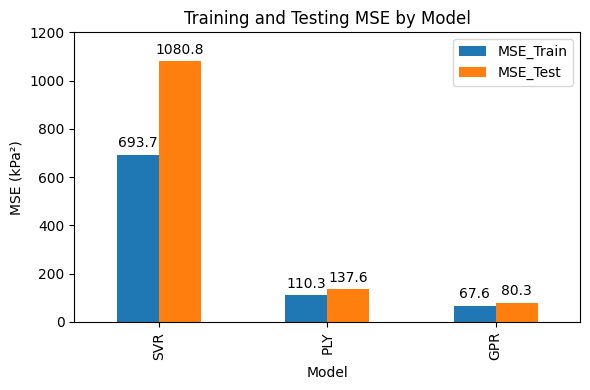

In [31]:
# Plot grouped bar chart
ax = mse_df.plot(kind="bar", figsize=(6, 4))

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

ax.set_xlabel("Model")
ax.set_ylabel("MSE (kPa²)")
ax.set_ylim(0, 1200)
ax.set_title("Training and Testing MSE by Model")
plt.tight_layout()
plt.savefig("results/mse_bar_chart.png", dpi=300, bbox_inches="tight")
plt.show()

## 4) Uncertainty Propagation

In [32]:
# Constants
N = 10000 #sample size
gamma = 0.5772156649  # Euler-Mascheroni constant for gumbel distribution

def get_lognormal_params(mean, sd):
    var = sd**2
    sigma = np.sqrt(np.log(1 + var / mean**2))
    mu = np.log(mean) - 0.5 * sigma**2
    return mu, sigma

def get_gumbel_params(mean, sd):
    scale = sd * np.sqrt(6) / np.pi
    loc = mean - scale * gamma
    return loc, scale

def get_uniform_params(mean, sd):
    # SD = (high - low) / sqrt(12)
    # Mean = (high + low) / 2
    delta = sd * np.sqrt(3)
    low = mean - delta
    high = mean + delta
    return low, high

# Generate data
data = {}

# f_mem: Gumbel
loc, scale = get_gumbel_params(0.4, 0.12)
data['f_mem'] = np.random.gumbel(loc, scale, N)

# Lognormal variables
lognorm_vars = {
    'sigma_mem_y': (11000, 1650),
    'sigma_mem': (4000, 800),
    'E_mem': (600000, 90000),
    'sigma_edg': (353677.6513, 70735.53026),
    'sigma_sup': (400834.6715, 80166.9343)
}

for name, (m, s) in lognorm_vars.items():
    mu, sigma = get_lognormal_params(m, s)
    data[name] = np.random.lognormal(mu, sigma, N)

# nu_mem: Uniform
low, high = get_uniform_params(0.4, 0.01154700538)
data['nu_mem'] = np.random.uniform(low, high, N)

try:
    samples_df = pd.read_csv('sample_points.csv')
except FileNotFoundError:
    # Create DataFrame
    samples_df = pd.DataFrame(data)
    # Save to CSV
    samples_df.to_csv('sample_points.csv', index=False)

# Summary statistics for verification
summary = samples_df.agg(['mean', 'std']).T
summary['variance'] = summary['std']**2
print(summary)

                      mean           std      variance
f_mem             0.400017      0.122363  1.497269e-02
sigma_mem_y   11006.915552   1647.463875  2.714137e+06
sigma_mem      4004.092529    800.288791  6.404621e+05
E_mem        599744.298013  91200.170008  8.317471e+09
sigma_edg    354031.078148  70842.419793  5.018648e+09
sigma_sup    400039.964252  81926.101818  6.711886e+09
nu_mem            0.400013      0.011426  1.305524e-04


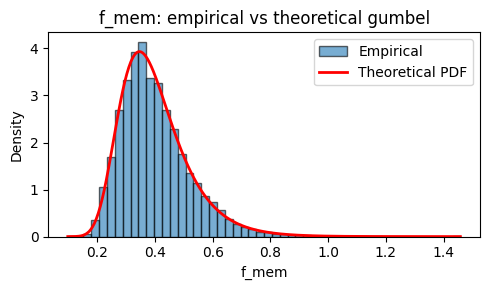

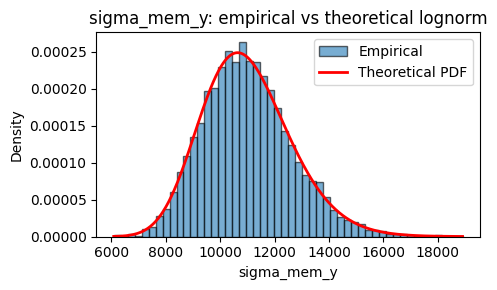

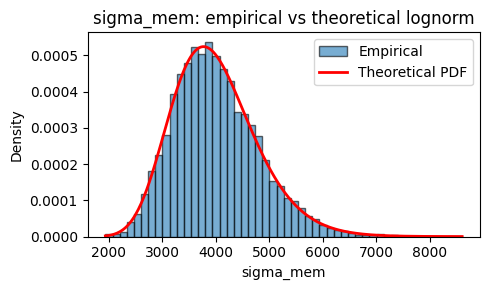

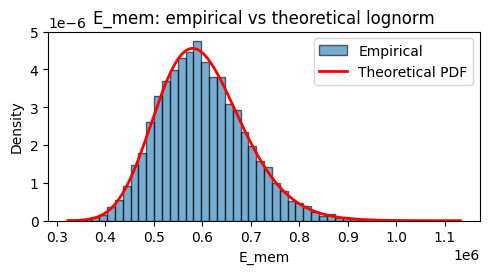

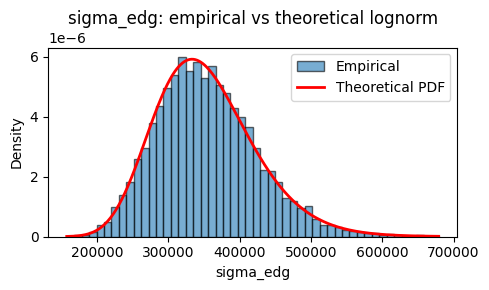

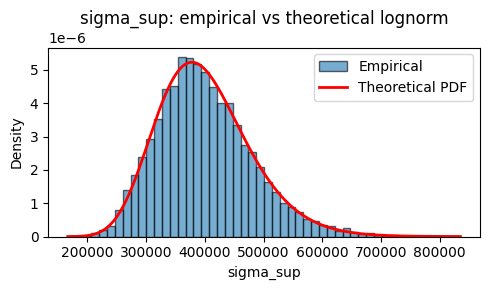

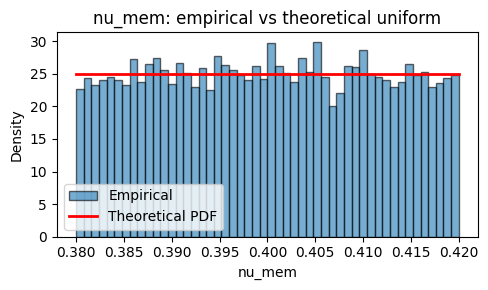

In [33]:
# just a verfication of distributions

from scipy.stats import lognorm, gumbel_r, uniform

gamma = 0.5772156649  # Euler–Mascheroni constant

# helper functions (mean, sd) -> distribution parameters
def get_lognormal_params(mean, sd):
    var = sd**2
    sigma = np.sqrt(np.log(1 + var / mean**2))
    mu = np.log(mean) - 0.5 * sigma**2
    return mu, sigma

def get_gumbel_params(mean, sd):
    scale = sd * np.sqrt(6) / np.pi
    loc = mean - scale * gamma
    return loc, scale

def get_uniform_params(mean, sd):
    delta = sd * np.sqrt(3)
    low = mean - delta
    high = mean + delta
    return low, high

target_params = {
    'f_mem':       ('gumbel',   0.4,        0.12),
    'sigma_mem_y': ('lognorm',  11000,      1650),
    'sigma_mem':   ('lognorm',  4000,       800),
    'E_mem':       ('lognorm',  600000,     90000),
    'sigma_edg':   ('lognorm',  353677.6513, 70735.53026),
    'sigma_sup':   ('lognorm',  400834.6715, 80166.9343),
    'nu_mem':      ('uniform',  0.4,        0.01154700538),
}

# load samples
samples_df = pd.read_csv("sample_points.csv")

for name, (dist_type, m_target, s_target) in target_params.items():
    x = samples_df[name].values

    # build theoretical distribution
    if dist_type == 'lognorm':
        mu, sigma = get_lognormal_params(m_target, s_target)
        shape = sigma
        scale = np.exp(mu)
        dist = lognorm(s=shape, scale=scale)
    elif dist_type == 'gumbel':
        loc, scale = get_gumbel_params(m_target, s_target)
        dist = gumbel_r(loc=loc, scale=scale)
    elif dist_type == 'uniform':
        low, high = get_uniform_params(m_target, s_target)
        dist = uniform(loc=low, scale=high - low)
    else:
        continue

    # grid and PDF
    xs = np.linspace(x.min(), x.max(), 400)
    pdf = dist.pdf(xs)

    # plot empirical + theoretical
    plt.figure(figsize=(5, 3))
    plt.hist(x, bins=50, density=True, alpha=0.6, edgecolor='k', label='Empirical')
    plt.plot(xs, pdf, 'r-', lw=2, label='Theoretical PDF')
    plt.title(f'{name}: empirical vs theoretical {dist_type}')
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [34]:
samples_df = samples_df[['f_mem','sigma_mem','E_mem','nu_mem','sigma_edg','sigma_sup']]
samples_df.head()
samples = samples_df.values

In [35]:
poly.predict(samples[0:10])

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([5490.28901174, 5601.69053691, 4330.12129635, 6036.37014966,
       6903.1560084 , 4497.79035799, 5344.15778607, 4686.5053377 ,
       5965.08856618, 5568.03075001])

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def uncertainty(model, samples, model_name="Surrogate Model", unit="Units"):
    """
    Performs uncertainty quantification on a model using provided samples.
    
    Parameters:
    model: Trained sklearn-compatible model (SVR, GP, etc.)
    samples: (N, features) array of Monte Carlo samples
    model_name: String for plot titles
    unit: String for axis labels (e.g., 'MPa' or 'kN')
    """
    # 1. Generate Predictions
    predictions = model.predict(samples).flatten()
    
    # 2. Calculate Statistics
    mu = np.mean(predictions)
    sigma = np.std(predictions)
    cv = (sigma / mu) * 100 if mu != 0 else 0  # Coefficient of Variation
    
    # 3. Create Visualization
    plt.rcParams.update({'font.size': 14}) # Base font size

    # Adjusted figure for a single, prominent plot
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # --- Plot 1: Histogram & KDE ---
    sns.histplot(predictions, kde=True, ax=ax1, color='teal', bins=40, stat="density", alpha=0.4)

    # Vertical lines for statistical markers
    ax1.axvline(mu, color='red', linestyle='--', linewidth=2, label=f'Mean: {mu:.2f} {unit}')
    ax1.axvline(mu - 2*sigma, color='orange', linestyle=':', linewidth=2, label=f'±2σ (95% CI)')
    ax1.axvline(mu + 2*sigma, color='orange', linestyle=':', linewidth=2)

    # Set labels and titles with larger font sizes
    ax1.set_title(f"Marginal Probability Density: {model_name}", fontsize=20, pad=20)
    ax1.set_xlabel(f"Predicted Output ({unit})", fontsize=16, labelpad=15)
    ax1.set_ylabel("Probability Density", fontsize=16, labelpad=15)

    # Axis limits
    ax1.set_xlim(3000, 9000)
    ax1.set_ylim(0, 0.001)

    # Legend and tick formatting
    ax1.legend(fontsize=14, loc='upper right')
    ax1.tick_params(axis='both', which='major', labelsize=13)

    plt.tight_layout()
    plt.show()
    
    # 4. Return Summary Report
    return {
        "Mean": mu,
        "Std_Dev": sigma,
        "COV_Percent": cv,
        "Min": np.min(predictions),
        "Max": np.max(predictions),
        "predictions": predictions
    }

/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


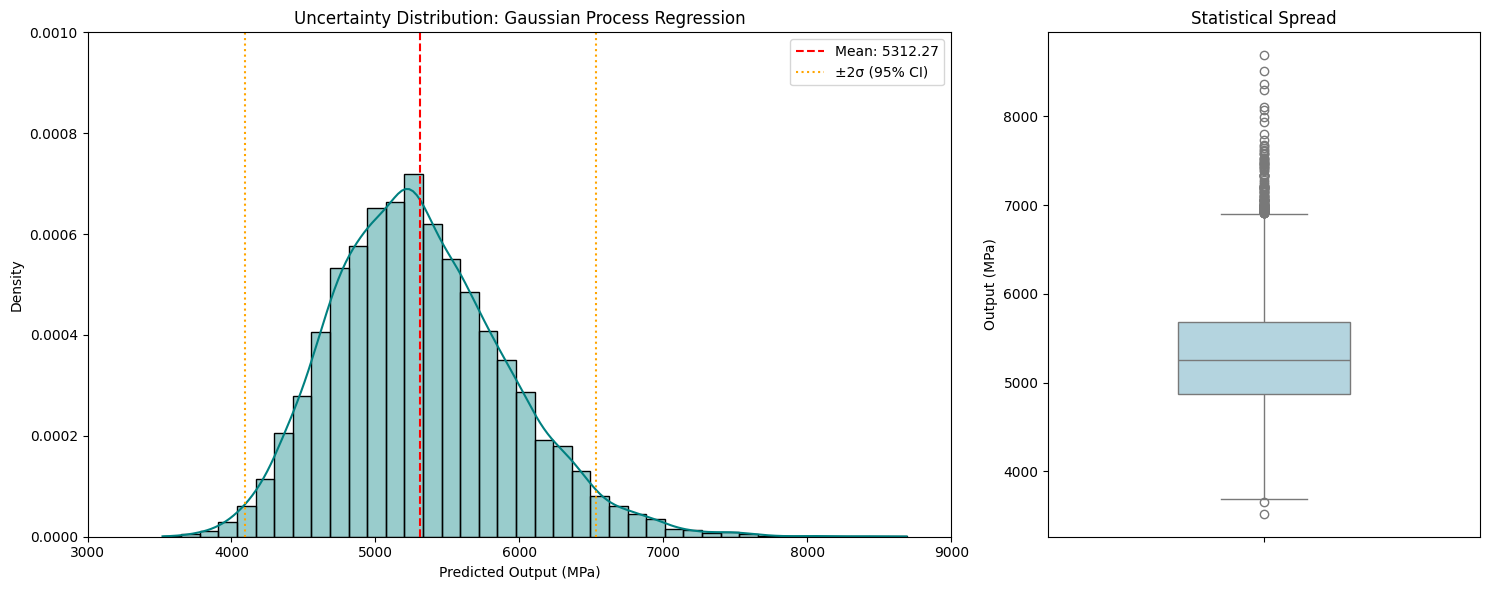

In [37]:
uncertainty_gpr = uncertainty(gpr, samples, model_name="GPR", unit="kPa")

In [38]:
y_hat_gpr = uncertainty_gpr['predictions']
type(y_hat_gpr) # 10000 ndarray

numpy.ndarray

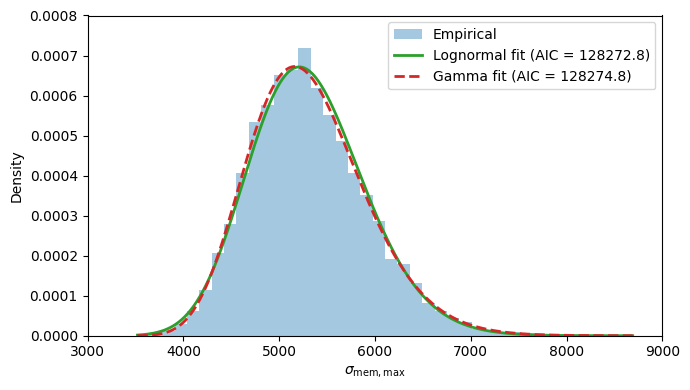

In [59]:
from scipy.stats import gamma, lognorm

# --- 1) Lognormal fit (only positive values) ---
y_pos = y_hat_gpr[y_hat_gpr > 0]
log_data = np.log(y_pos)
mu_log = np.mean(log_data)
sigma_log = np.std(log_data, ddof=1)
shape = sigma_log              # shape parameter
scale = np.exp(mu_log)         # scale parameter


# 2) Gamma fit (only positive values) ---
y_pos = y_hat_gpr[y_hat_gpr > 0]
shape_gamma, loc_gamma, scale_gamma = gamma.fit(y_pos)

# --- Grid for pdfs ---
x_min = max(0, y_hat_gpr.min())
x_max = y_hat_gpr.max()
x = np.linspace(x_min, x_max, 500)


pdf_logn = lognorm.pdf(x, s=shape, scale=scale)
pdf_gamma = gamma.pdf(x, a=shape_gamma, loc=loc_gamma, scale=scale_gamma)

GPR_logn_AIC = 128272.81692383962
GPR_gamma_AIC = 128274.81549479174

plt.figure(figsize=(7,4))
plt.hist(y_hat_gpr, bins=40, density=True, alpha=0.4, color='C0',
         label='Empirical') 

plt.plot(
    x, pdf_logn, 'C2-', lw=2,
    label=fr'Lognormal fit (AIC = {GPR_logn_AIC:.1f})'
)
plt.plot(
    x, pdf_gamma, 'C3--', lw=2,
    label=fr'Gamma fit (AIC = {GPR_gamma_AIC:.1f})'
)

plt.xlabel(r'$\sigma_{\mathrm{mem,max}}$')
plt.ylabel('Density')
plt.legend()
plt.xlim(3000, 9000)
plt.ylim(0, 0.0008)
plt.tight_layout()
plt.savefig("results/fit_gpr.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# AIC of Lognormal
def aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

n = len(y_hat_gpr)
k_logn = 2  # mu and sigma
k_gamma = 3  # shape, loc, scale
# Lognormal RSS
rss_logn_gpr = np.sum((y_hat_gpr - lognorm.mean(s=shape, scale=scale))**2)
aic_logn_gpr = aic(n, rss_logn_gpr, k_logn)
print("GPR Lognormal AIC:", aic_logn_gpr)

# Gamma RSS
rss_gamma_gpr = np.sum((y_hat_gpr - gamma.mean(a=shape_gamma, loc=loc_gamma, scale=scale_gamma))**2)
aic_gamma_gpr = aic(n, rss_gamma_gpr, k_gamma)
print("GPR Gamma AIC:", aic_gamma_gpr)


# MSE for Lognormal and Gamma fits
mse_logn_gpr = mean_squared_error(y_hat_gpr, lognorm.mean(s=shape, scale=scale) * np.ones_like(y_hat_gpr))
mse_gamma_gpr = mean_squared_error(y_hat_gpr, gamma.mean(a=shape_gamma, loc=loc_gamma, scale=scale_gamma) * np.ones_like(y_hat_gpr))
print("GPR Lognormal MSE:", mse_logn_gpr)
print("GPR Gamma MSE:", mse_gamma_gpr)

# Root mean squared error
rmse_logn_gpr = np.sqrt(mse_logn_gpr)
rmse_gamma_gpr = np.sqrt(mse_gamma_gpr)
print("GPR Lognormal RMSE:", rmse_logn_gpr)
print("GPR Gamma RMSE:", rmse_gamma_gpr)

# R²
r2_logn_gpr = 1 - (np.sum((y_hat_gpr - lognorm.mean(s=shape, scale=scale))**2) / np.sum((y_hat_gpr - np.mean(y_hat_gpr))**2))
r2_gamma_gpr = 1 - (np.sum((y_hat_gpr - gamma.mean(a=shape_gamma, loc=loc_gamma, scale=scale_gamma))**2) / np.sum((y_hat_gpr - np.mean(y_hat_gpr))**2))
print("GPR Lognormal R²:", r2_logn_gpr)
print("GPR Gamma R²:", r2_gamma_gpr)



GPR Lognormal AIC: 128272.81692383962
GPR Gamma AIC: 128274.81549479174
GPR Lognormal MSE: 372086.5220562253
GPR Gamma MSE: 372086.4688832835
GPR Lognormal RMSE: 609.9889524050623
GPR Gamma RMSE: 609.9889088198928
GPR Lognormal R²: -1.429047988832366e-07
GPR Gamma R²: -4.440892098500626e-16
GPR Lognormal RMSE: 609.9889524050623
GPR Gamma RMSE: 609.9889088198928


In [40]:
# --- Normal ---
mu = y_hat_gpr.mean()
sigma = y_hat_gpr.std(ddof=1)
ll_norm = np.sum(norm.logpdf(y_hat_gpr, loc=mu, scale=sigma))
k_norm = 2
AIC_norm = 2 * k_norm - 2 * ll_norm

# --- Lognormal (positive data only) ---
y_pos = y_hat_gpr[y_hat_gpr > 0]
log_y = np.log(y_pos)
mu_log = log_y.mean()
sigma_log = log_y.std(ddof=1)
shape = sigma_log
scale = np.exp(mu_log)
ll_logn = np.sum(lognorm.logpdf(y_pos, s=shape, scale=scale))
k_logn = 2
AIC_logn = 2 * k_logn - 2 * ll_logn





AIC = pd.DataFrame(data={
    "Normal AIC": [AIC_norm],
    "Lognormal AIC": [AIC_logn],
    "difference": [AIC_norm - AIC_logn]
},
index=["GPR"]
)

AIC

,Normal AIC,Lognormal AIC,difference
GPR,156651.586209,156249.193825,402.392384


/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


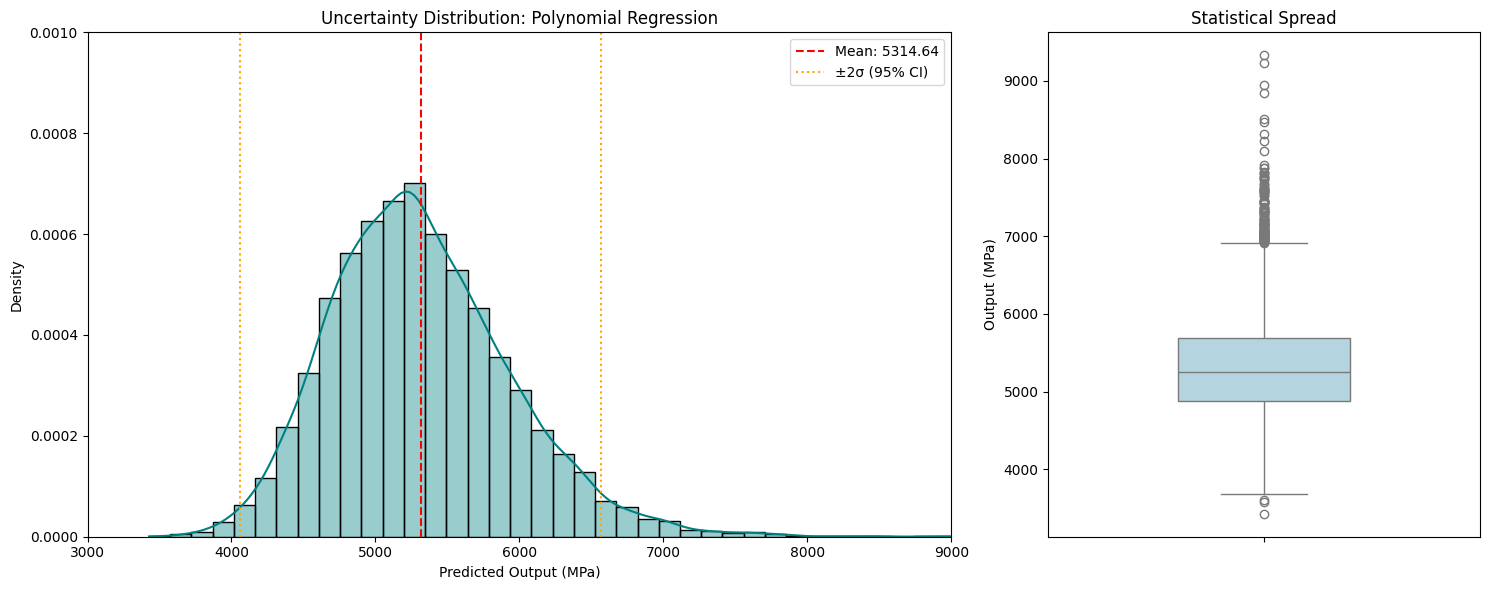

In [41]:
uncertainty_poly = uncertainty(poly, samples, model_name="Polynomial Regression", unit="MPa")

In [42]:
y_hat_poly = uncertainty_poly['predictions']

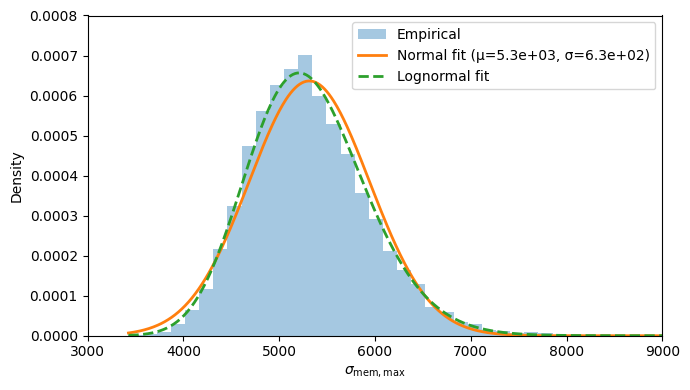

In [ ]:
# --- 1) Lognormal fit (only positive values) ---
y_pos = y_hat_poly[y_hat_poly > 0]
log_data = np.log(y_pos)
mu_log = np.mean(log_data)
sigma_log = np.std(log_data, ddof=1)
shape = sigma_log              # shape parameter
scale = np.exp(mu_log)         # scale parameter


# --- Grid for pdfs ---
x_min = max(0, y_hat_poly.min())
x_max = y_hat_poly.max()
x = np.linspace(x_min, x_max, 500)

pdf_logn = lognorm.pdf(x, s=shape, scale=scale)

# --- Plot ---
plt.figure(figsize=(7,4))
plt.hist(y_hat_poly, bins=40, density=True, alpha=0.4, color='C0', label='Empirical')
plt.plot(x, pdf_norm, 'C1-',  lw=2, label=f'Normal fit (μ={mu:.2g}, σ={sigma:.2g})')
plt.plot(x, pdf_logn, 'C2--', lw=2, label='Lognormal fit')
plt.xlabel(r'$\sigma_{\mathrm{mem,max}}$')
plt.ylabel('Density')
plt.legend()
plt.xlim(3000, 9000)   # X-axis range
plt.ylim(0, 0.0008)       # Y-axis range
plt.tight_layout()
plt.savefig("results/fit_poly.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
# --- Normal ---
mu = y_hat_poly.mean()
sigma = y_hat_poly.std(ddof=1)
ll_norm = np.sum(norm.logpdf(y_hat_poly, loc=mu, scale=sigma))
k_norm = 2
AIC_norm = 2 * k_norm - 2 * ll_norm

# --- Lognormal (positive data only) ---
y_pos = y_hat_poly[y_hat_poly > 0]
log_y = np.log(y_pos)
mu_log = log_y.mean()
sigma_log = log_y.std(ddof=1)
shape = sigma_log
scale = np.exp(mu_log)
ll_logn = np.sum(lognorm.logpdf(y_pos, s=shape, scale=scale))
k_logn = 2
AIC_logn = 2 * k_logn - 2 * ll_logn




AIC.loc["Poly"] = [
    AIC_norm,
    AIC_logn,
    AIC_norm - AIC_logn
]
AIC



,Normal AIC,Lognormal AIC,difference
GPR,156651.586209,156249.193825,402.392384
Poly,157193.814429,156705.439935,488.374494


/Users/anirudhparameswaran/Desktop/Case Studies - Computer Experiments/SVM/csenv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


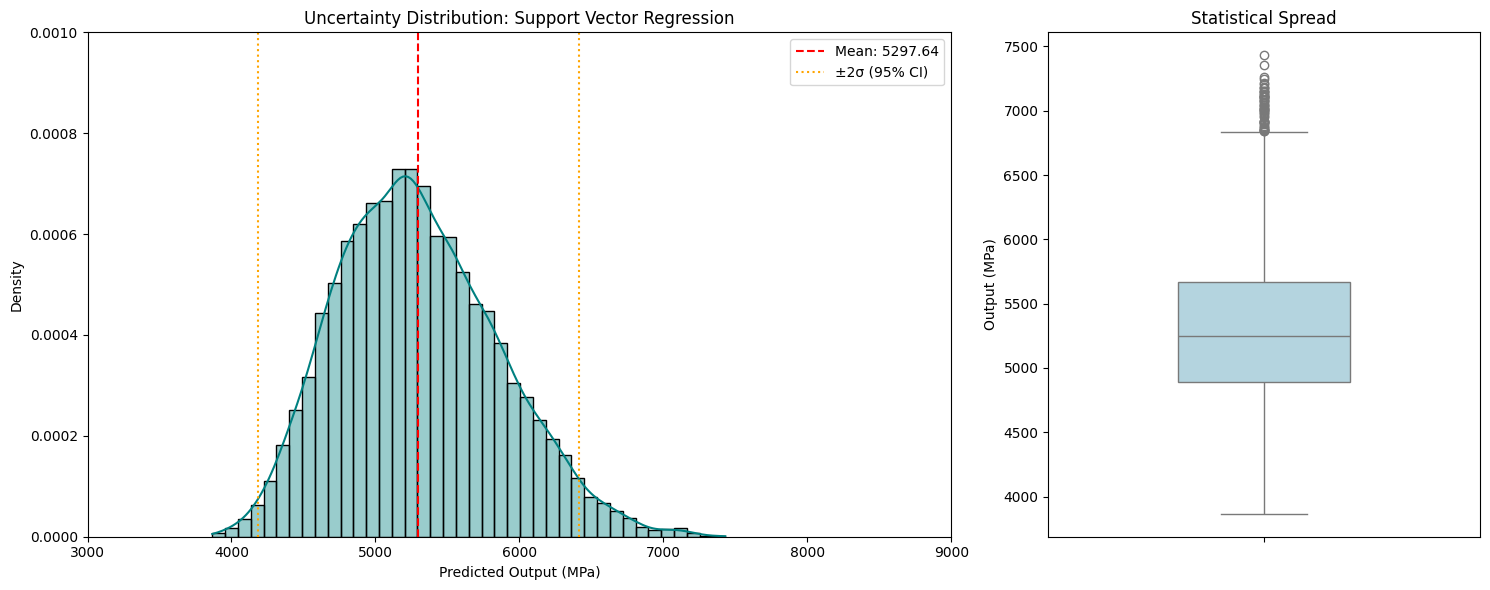

In [45]:
uncertainty_svr = uncertainty(svr, samples, model_name="Support Vector Regression", unit="MPa")

In [46]:
y_hat_svr = uncertainty_svr['predictions']

y_hat_svr

array([5479.0884158 , 5560.55711468, 4446.62864532, ..., 6510.85581406,
       5564.26409111, 5533.81779773], shape=(10000,))

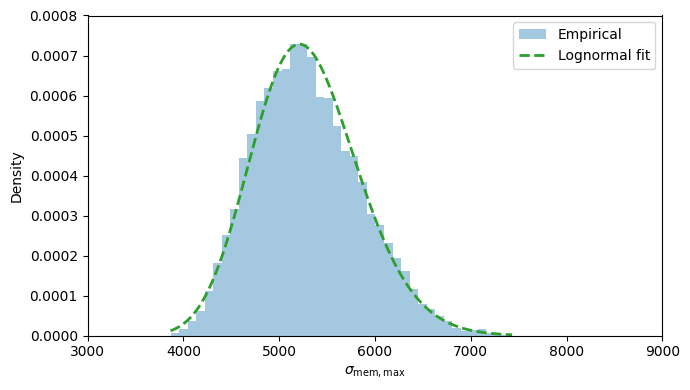

In [ ]:


# --- 1) Lognormal fit (only positive values) ---
y_pos = y_hat_svr[y_hat_svr > 0]
log_data = np.log(y_pos)
mu_log = np.mean(log_data)
sigma_log = np.std(log_data, ddof=1)
shape = sigma_log              # shape parameter
scale = np.exp(mu_log)         # scale parameter



# --- Grid for pdfs ---
x_min = max(0, y_hat_svr.min())
x_max = y_hat_svr.max()
x = np.linspace(x_min, x_max, 500)

pdf_logn = lognorm.pdf(x, s=shape, scale=scale)

# --- Plot ---
plt.figure(figsize=(7,4))
plt.hist(y_hat_svr, bins=40, density=True, alpha=0.4, color='C0', label='Empirical')
plt.plot(x, pdf_logn, 'C2--', lw=2, label='Lognormal fit')
plt.xlabel(r'$\sigma_{\mathrm{mem,max}}$')
plt.ylabel('Density')
plt.legend()
plt.xlim(3000, 9000)   # X-axis range
plt.ylim(0, 0.0008)       # Y-axis range
plt.tight_layout()
plt.savefig("results/fit_svr.png", dpi=300, bbox_inches="tight")
plt.show()

In [48]:

# --- Normal ---
mu = y_hat_svr.mean()
sigma = y_hat_svr.std(ddof=1)
ll_norm = np.sum(norm.logpdf(y_hat_svr, loc=mu, scale=sigma))
k_norm = 2
AIC_norm = 2 * k_norm - 2 * ll_norm

# --- Lognormal (positive data only) ---
y_pos = y_hat_svr[y_hat_svr > 0]
log_y = np.log(y_pos)
mu_log = log_y.mean()
sigma_log = log_y.std(ddof=1)
shape = sigma_log
scale = np.exp(mu_log)
ll_logn = np.sum(lognorm.logpdf(y_pos, s=shape, scale=scale))
k_logn = 2
AIC_logn = 2 * k_logn - 2 * ll_logn

AIC.loc["SVR"] = [
    AIC_norm,
    AIC_logn,
    AIC_norm - AIC_logn
]
AIC

,Normal AIC,Lognormal AIC,difference
GPR,156651.586209,156249.193825,402.392384
Poly,157193.814429,156705.439935,488.374494
SVR,154874.776892,154606.506761,268.270131
